# Fit quality visualization notebook

In [1]:
!pip install -q arviz

In [2]:
import math
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import pystan

### Parameters changed by Papermill

In [9]:
model_name = 'reducedlinearmodelR0'
roi = 'US_OK'
data_path = "../data"
fits_path = "/home/rgerkin/dev/covid-fits"

### Load the data

In [10]:
data_path = Path(data_path) / ("covid_timeseries_%s.csv" % roi)
data = pd.read_csv(data_path)

### Load the fits

In [11]:
fits_path = Path(fits_path) / ("model_fit_%s_%s.pkl" % (model_name, roi))
with open(fits_path, "rb") as f:
    fit = pickle.load(f)
samples = fit['samples']
summary = fit['summary']

### Choose the parameter list

In [12]:
params = ['theta[%d]' % i for i in range(1, 9)]

### Visualize samples (one histogram and color per chain)

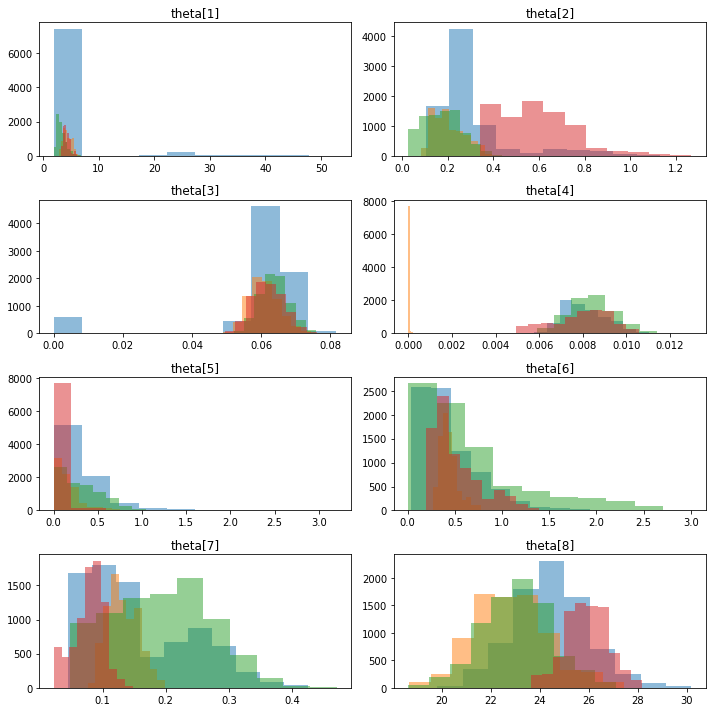

In [13]:
fig, axes = plt.subplots(4, math.ceil(len(params)/4), figsize=(10,10))
chains = samples['chain'].unique()
for i, param in enumerate(params):
    ax = axes.flat[i]
    for chain in chains:
        chain_samples = samples[samples['chain']==chain][param]
        ax.hist(chain_samples, alpha=0.5)
        ax.set_title(param)
plt.tight_layout()

### Visualize data and fits

t0 index assumed to be: day 8
t0 date: 03/15/20
tm index assumed to be: day 18
mitigation date: 03/25/20


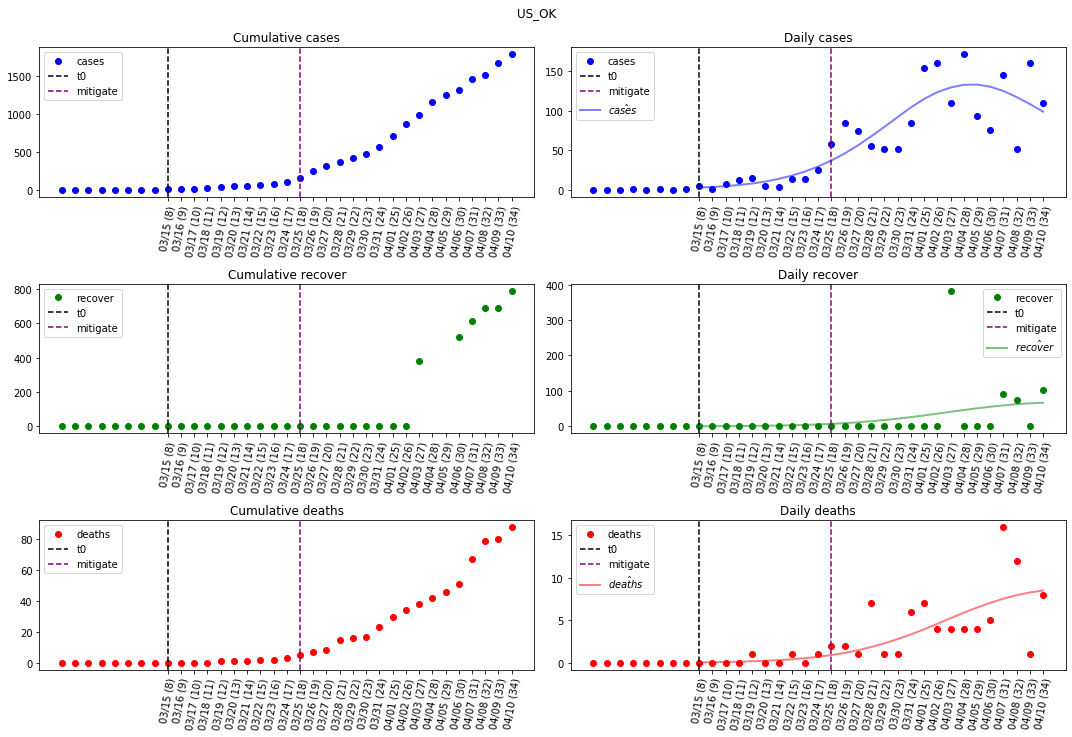

In [19]:
t0 = np.where(data["new_cases"].values>=5)[0][0] 
tm = t0 + 10
days, day_labels = zip(*data['dates2'][t0:].apply(lambda x:x[:-3]).iteritems())
day_labels = ['%s (%d)' % (day_labels[i], days[i]) for i in range(len(days))]

fig, ax = plt.subplots(3, 2, figsize=(15, 10))

estimates = {}
for chain in chains:
    chain_samples = samples[samples['chain']==chain]
    estimates['cases'] = [chain_samples['lambda[%d,1]' % (day-t0+1)].mean() for day in days]
    estimates['recover'] = [chain_samples['lambda[%d,2]' % (day-t0+1)].mean() for day in days]
    estimates['deaths'] = [chain_samples['lambda[%d,3]' % (day-t0+1)].mean() for day in days]

for i, kind in enumerate(['cases', 'recover', 'deaths']):
    colors = 'bgr'
    ax[i, 0].set_title('Cumulative %s' % kind)
    ax[i, 0].plot(data["cum_%s" % kind],'bo', color=colors[i], label=kind)
    ax[i, 0].axvline(t0, color='k', linestyle="dashed", label='t0')
    ax[i, 0].axvline(tm, color='purple', linestyle="dashed", label='mitigate')
    ax[i, 0].set_xticks(days)
    ax[i, 0].set_xticklabels(day_labels, rotation=80)
    ax[i, 0].legend()

    ax[i, 1].set_title('Daily %s' % kind)
    ax[i, 1].plot(data["new_%s" % kind], 'bo', color=colors[i], label=kind)
    ax[i, 1].axvline(t0, color='k', linestyle="dashed", label='t0')
    ax[i, 1].axvline(tm, color='purple', linestyle="dashed", label='mitigate')
    ax[i, 1].set_xticks(days)
    ax[i, 1].set_xticklabels(day_labels, rotation=80)
    if kind in estimates:
        ax[i, 1].plot(days, estimates[kind], label=r'$\hat{%s}$'% kind, linewidth=2, alpha=0.5, color=colors[i])
    ax[i, 1].legend()
    
plt.tight_layout()
fig.suptitle(roi, y=1.02)

print("t0 index assumed to be: day "+str(t0))
print("t0 date: "+data['dates2'][t0])
print("tm index assumed to be: day "+str(tm))
print("mitigation date: "+data['dates2'][tm])

### Print plain summary

In [8]:
print(summary)

Inference for Stan model: anon_model_d2e0f34e0bdb79700cf62e71c18f0fb0.
4 chains, each with iter=10000; warmup=2000; thin=1; 
post-warmup draws per chain=8000, total post-warmup draws=32000.

                mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
theta[1]       26.24   16.23   44.54    1.73    5.26   10.87    26.3  175.33      8   1.49
theta[2]        0.75    0.04    0.12    0.47    0.69    0.76    0.82    0.94     10   1.23
theta[3]      2.1e-4  5.8e-6  3.6e-5  1.6e-4  1.8e-4  2.0e-4  2.2e-4  3.1e-4     38   1.07
theta[4]      2.1e-8  2.4e-8  3.3e-8 2.9e-12 7.9e-10  2.6e-9  4.0e-8  8.3e-8      2  30.94
theta[5]     2.8e-12 2.4e-12 3.4e-12 7.7e-14 1.9e-13 1.3e-12 4.8e-12 9.3e-12      2  12.28
theta[6]      4.8e-3  3.3e-3    0.01  1.8e-5  5.7e-4  1.4e-3  3.6e-3    0.04     13   1.25
theta[7]        0.55    0.03    0.08    0.34    0.51    0.57    0.61    0.65      5   1.96
theta[8]        5.22    0.27    1.64    3.48     4.5     4.9    5.46   12.41     